# Sentiment analysis of the reviews

#### The reviews are provided in a dataset with no classification (positive/negative or a punctuation). Therefore, a sentiment analysis is needed to perform this classification. After that, three different visualizations are performed:
 - the negative reviews are grouped based on the issue and are visualize in a heat map. That way we can see if there are conflictive areas inside Madrid for each issue.
 - the location of the negative reviews are plotted by neighbourhood. That way we can see if there are conflictive areas inside each neighbourhood.
 - Wordclouds per neighbourhood for the positive and the negative reviews.

In [8]:
import pandas as pd
import pymongo
from pymongo import MongoClient
import pickle
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import webtext
from nltk.probability import FreqDist
from functools import reduce
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta

#### Some functions are defined now to be used later:

In [9]:
#Function to pre-process the text:
def pre_processing_es(text):
    text = text.str.lower()
    
    deletePunct = re.compile(r'[\.,_:¡!*?¿;\-"\(\)\[\]\{\}%\'�=$&+æ<></ \>#@ \ ]')
    text = text.apply(lambda x: deletePunct.sub(" ", x).strip())
    
    delete2Spaces = re.compile(r'\s{2,}')
    text = text.apply(lambda x: delete2Spaces.sub(" ", x))
    
    deleteNumbers = re.compile(r'[0-9]')
    text = text.apply(lambda x: deleteNumbers.sub("", x))
    
    stop = stopwords.words('spanish')
    text = text.apply(lambda x: " ".join([i for i in x.split() if i not in stop]))
    
    return text

In [10]:
#Function to create a WordCloud for Madrid:
def wordClouds_from_frequency(frequency_list):
    wcloud = WordCloud(width=1500, 
                       height=750,
                       max_words=100,
                       background_color="white",
                       colormap="Spectral").generate_from_frequencies(frequency_list)
    plt.figure(figsize=(10, 10))
    plt.title('Word cloud for Apartments in Madrid', {'fontsize': 20}, pad = 20)
    plt.imshow(wcloud, interpolation="bilinear")
    plt.axis(False) 
    return plt.imshow(wcloud, interpolation="bilinear")

In [11]:
#Function to create a WordCloud for one neighbourhood:
def wordClouds_from_frequency_barrio(frequency_list):
    wcloud = WordCloud(width=1500, 
                       height=750,
                       max_words=100,
                       background_color="white",
                       colormap="Spectral").generate_from_frequencies(frequency_list)
    plt.figure(figsize=(10, 10))
    plt.title('Word cloud for ' + str(neig), {'fontsize': 20})
    plt.imshow(wcloud, interpolation="bilinear")
    plt.axis(False) 
    return plt.imshow(wcloud, interpolation="bilinear")

In [12]:
#Function to create a pair of WordClouds, one for positive reviews and one for the negative ones:
def pair_wordClouds(frequency_list_pos, frequency_list_neg):
    wcloud_pos = WordCloud(width=1500, 
                       height=750,
                       max_words=50,
                       background_color="white",
                       colormap="Spectral").generate_from_frequencies(frequency_list_pos)
    wcloud_neg = WordCloud(width=1500, 
                       height=750,
                       max_words=50,
                       background_color="white",
                       colormap="Spectral").generate_from_frequencies(frequency_list_neg)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].set_title('Positive reviews', {'fontsize': 15}, pad = 20)
    ax[0].imshow(wcloud_pos, interpolation="bilinear")
    ax[1].set_title('Negative reviews', {'fontsize': 15}, pad = 20)
    ax[1].imshow(wcloud_neg, interpolation="bilinear")
    fig.suptitle('Review wordclouds for ' + str(neig), fontsize = 20, y=0.95)
    fig.tight_layout()
    return fig

#### We have all the information in MongoDB, so we have to retrieve this information:

In [13]:
client = MongoClient('localhost', 27017)
db = client.proyecto
collection = db.traduccion

#To create the table:
dataset = pd.DataFrame(list(collection.find({})))

### Sentiment analysis (all reviews are already translated to Spanish)

#### We will use the library sentiment_analysis_spanish to do the sentiment analysis:

In [ ]:
 from sentiment_analysis_spanish import sentiment_analysis
 sentiment = sentiment_analysis.SentimentAnalysisSpanish() #1 pos, 0 neg

 for j in tqdm(range(dataset.shape[0])):
     dataset.loc[j, "sentimiento"] = sentiment.sentiment(dataset.loc[j, "review_spanish"])

#### We will create now a new columns with 0s or 1s depending on the result (Negative or Positive):

In [ ]:
result = []
for i in tqdm(range(dataset.shape[0])):
    if dataset.loc[i,"sentimiento"] < 0.001:
        result.append("Negative")
    if dataset.loc[i,"sentimiento"] >= 0.001:
        result.append("Positive")
dataset["Result"] = result

#dataset = pd.get_dummies(dataset, prefix=["Result"], columns=["Result"])

#### We need to add some additional information to the dataset, like the date of the review, and we have to change the column type:

In [ ]:
path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\Datos"
reviews = pd.read_csv(path + "/reviews.csv", quotechar='"', engine = "python", encoding = "utf8")
dataset = pd.merge(dataset, reviews[["id", "date"]], 
                                left_on='id_review', right_on='id', how='left')
dataset.drop(["id"], axis = 1, inplace = True)
dataset['date'] = pd.to_datetime(dataset['date'])

In [14]:
with open(r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\Datos\Pickles\sent_analysis_castellano.pk", "rb") as file:
    dataset = pickle.load(file)

In [15]:
dataset.head()

,_id,id_review,id_listing,language,review_spanish,confidence,trad,sentimiento,Result_Negative,Result_Positive,date
0,5f0439349d9e652b57a5d143,29428,6369,en,¡Simon y Arturo tienen la mejor ubicación en M...,1.0,1.0,1.000000,0,1,2010-03-14
1,5f0439349d9e652b57a5d144,31018,6369,en,Kristy y yo planeamos originalmente quedarnos ...,1.0,1.0,1.000000,0,1,2010-03-23
2,5f0439359d9e652b57a5d145,34694,6369,en,¡Lo pasamos muy bien en Arturo y Simon! Un aco...,1.0,1.0,0.999946,0,1,2010-04-10
3,5f0439359d9e652b57a5d146,37146,6369,en,Disfruté mucho la estancia.\r\nEs una habitaci...,1.0,1.0,1.000000,0,1,2010-04-21
4,5f0439359d9e652b57a5d147,38168,6369,en,Arturo y Simon son anfitriones educados y amab...,1.0,1.0,0.791686,0,1,2010-04-26


### Text pre-processing

#### Before begining with the plotting, we will perform a text pre-processing to work later with the Word Clouds:

In [17]:
dataset["review_spanish"] = pre_processing_es(dataset["review_spanish"])
#Removing the empty rows:
dataset["review_spanish"].replace('', np.nan, inplace=True)
dataset.dropna(subset=["review_spanish"], inplace=True)

#### We need to add some additional information to the dataset, like the room type, longitude, latitude, price, neighbourhodd:

In [19]:
path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\Datos"
caract = pd.read_csv(path + "\\listings.csv", quotechar='"', engine = "python", encoding = "utf8")
dataset_proc = pd.merge(dataset, caract[["id", "room_type", "longitude", "latitude", "price", "neighbourhood_group_cleansed"]], 
                                left_on='id_listing', right_on='id', how='left')

dataset_proc.drop(["id"], axis = 1, inplace = True)

### Splitting into Positive and Negative reviews

#### To perform a more accurate analysis, we will work with the reviews of the last 12 months:

In [20]:
value_to_check = pd.Timestamp(datetime.today() - timedelta(days = 365))
filter_mask = dataset_proc['date'] > value_to_check
filtered_dataset_proc = dataset_proc[filter_mask]

positivas = filtered_dataset_proc[filtered_dataset_proc["Result_Positive"] == 1]
positivas = positivas.reset_index(drop=True)
negativas = filtered_dataset_proc[filtered_dataset_proc["Result_Negative"] == 1]
negativas = negativas.reset_index(drop=True)

#### WordCloud for the positive reviews:

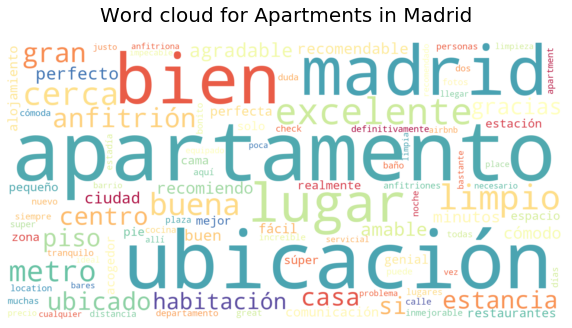

In [21]:
corpus = list()
stop = stopwords.words('english')
positivas["review_spanish"] = positivas["review_spanish"].apply(lambda x: " ".join([i for i in x.split() if i not in stop]))
for row in positivas["review_spanish"]:
    corpus.extend(row.split())
frequency_dist = nltk.FreqDist(corpus)
wordClouds_from_frequency(frequency_dist)

#### WordCloud for the negative reviews:

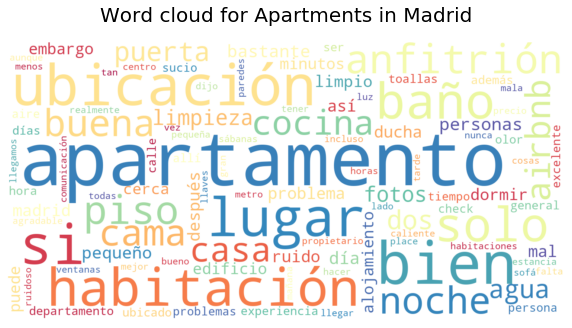

In [22]:
corpus = list()
negativas["review_spanish"] = negativas["review_spanish"].apply(lambda x: " ".join([i for i in x.split() if i not in stop]))
for row in negativas["review_spanish"]:
    corpus.extend(row.split())
frequency_dist = nltk.FreqDist(corpus)
wordClouds_from_frequency(frequency_dist)

#### WordClouds for the positive and negative reviwes per neighbourhood:

C:\Users\usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


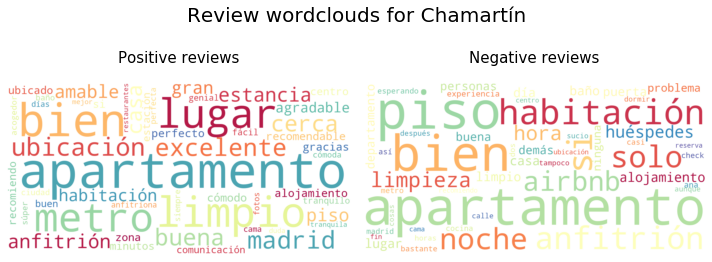

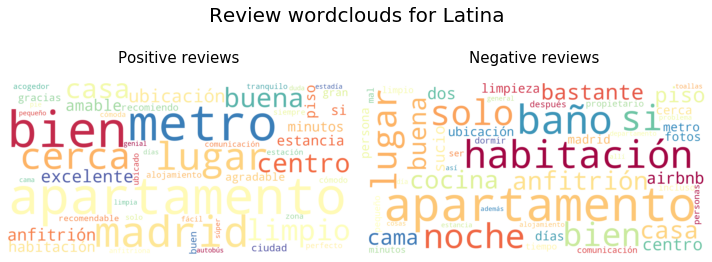

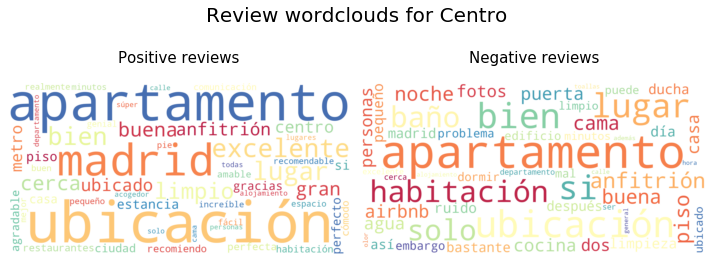

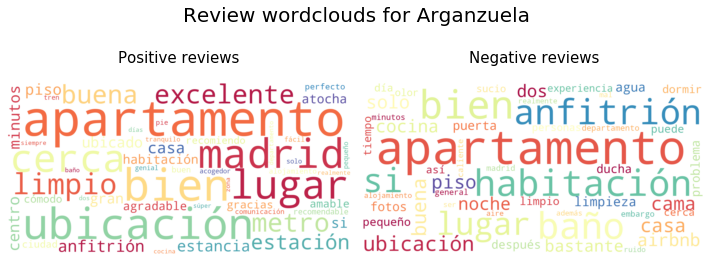

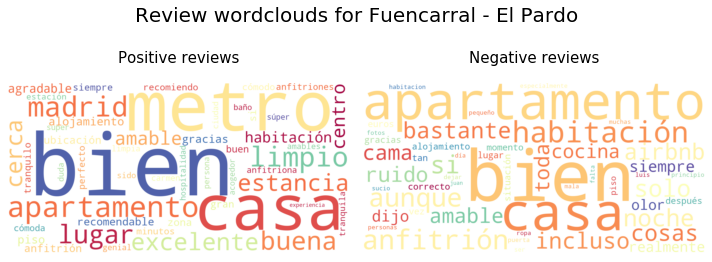

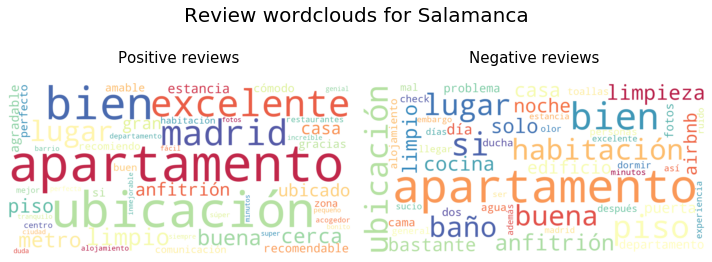

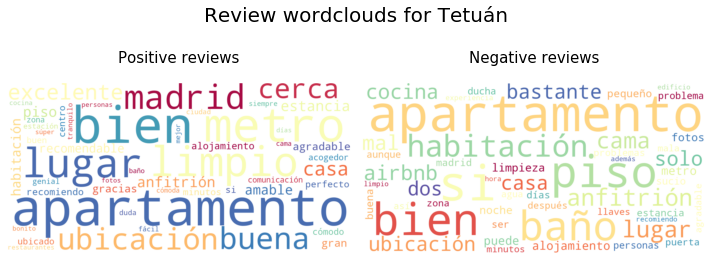

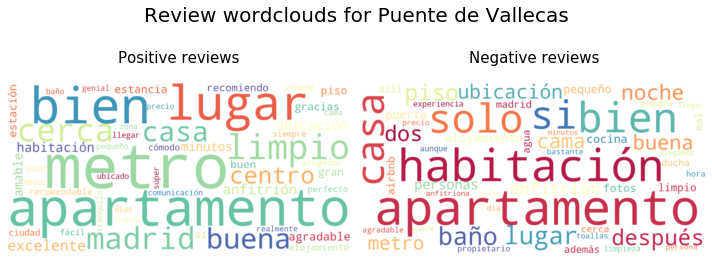

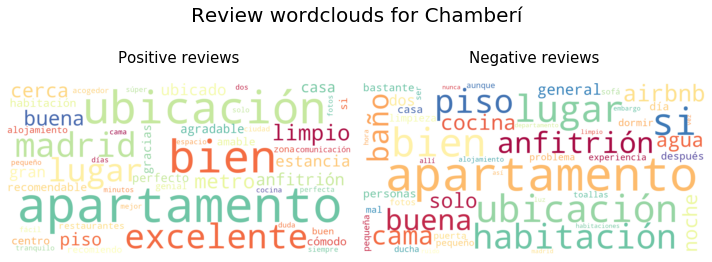

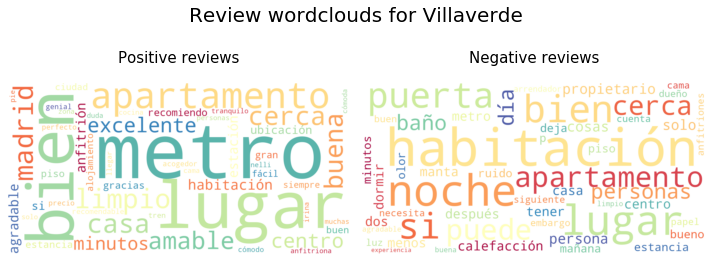

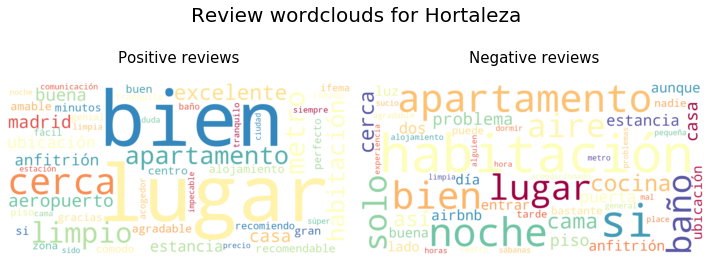

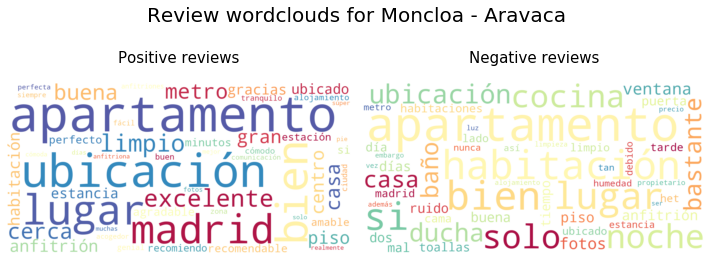

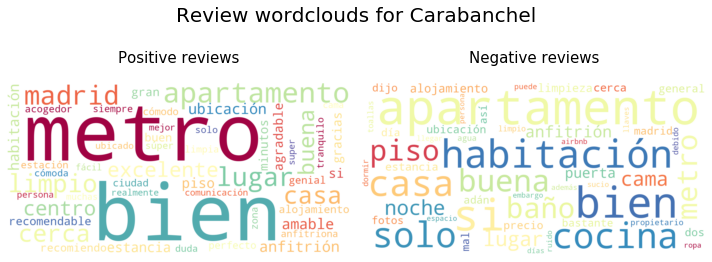

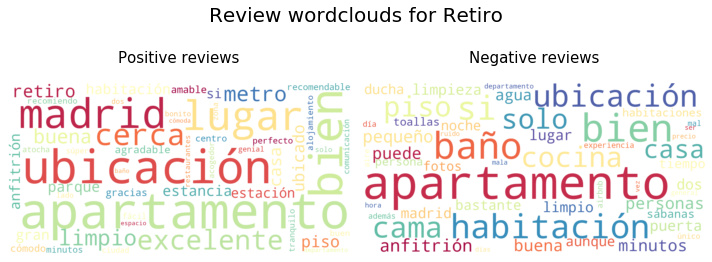

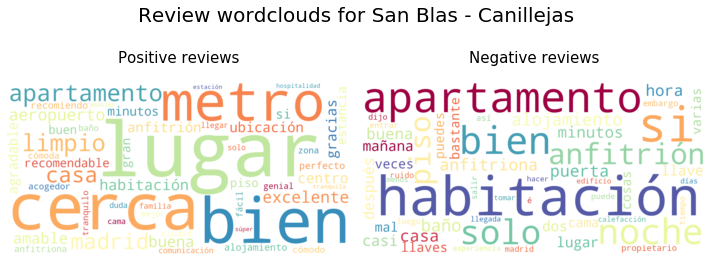

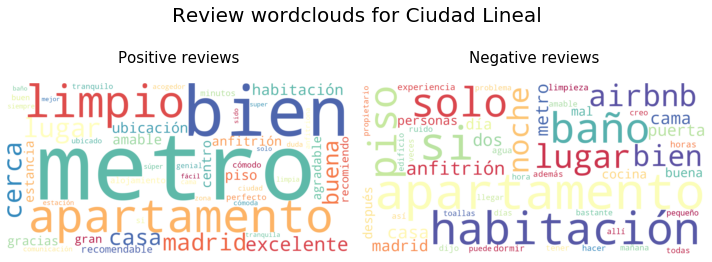

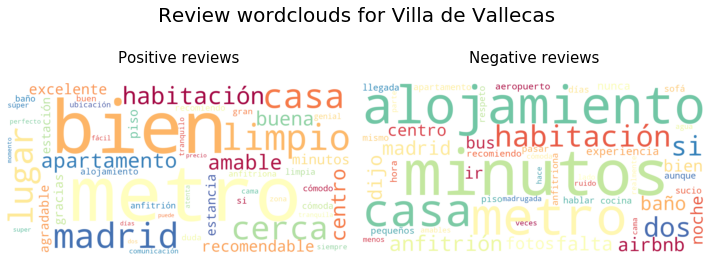

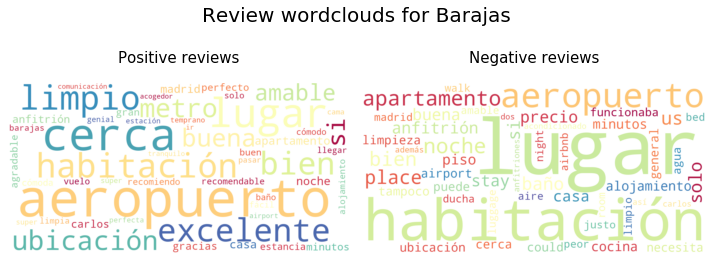

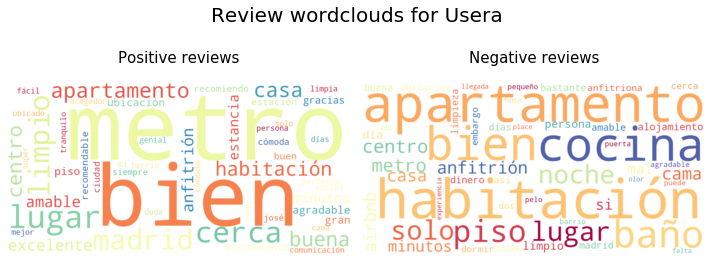

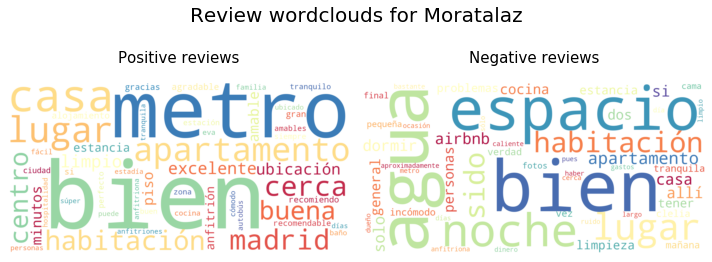

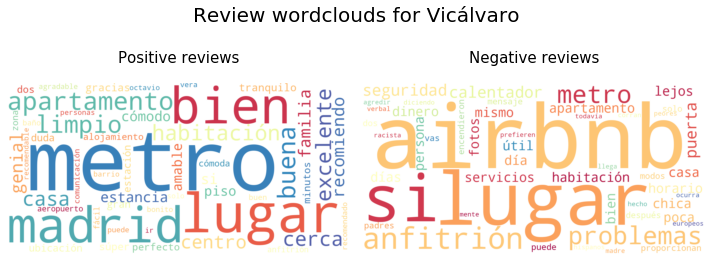

In [23]:
barrios = list(dataset_proc["neighbourhood_group_cleansed"].unique())
save_path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\assets"
for neig in barrios:
    rev_barrio_pos = positivas[positivas["neighbourhood_group_cleansed"] == neig]
    rev_barrio_neg = negativas[negativas["neighbourhood_group_cleansed"] == neig]
    corpus_pos = list()
    corpus_neg = list()
    for row in rev_barrio_pos["review_spanish"]:
        corpus_pos.extend(row.split())
    frequency_dist_pos = nltk.FreqDist(corpus_pos)
    for fila in rev_barrio_neg["review_spanish"]:
        corpus_neg.extend(fila.split())
    frequency_dist_neg = nltk.FreqDist(corpus_neg)
    #Eliminamos las palabras en inglés
    stop = stopwords.words('english')
    filtered_word_pos = dict((word, freq) for word, freq in frequency_dist_pos.items() if word not in stop)
    filtered_word_neg = dict((word, freq) for word, freq in frequency_dist_neg.items() if word not in stop)   
    pair_wordClouds(filtered_word_pos, filtered_word_neg)
    #plt.savefig("{}.png".format(save_path + "\\wordcloud_" + neig), dpi=500, bbox_inches='tight')

### Grouping reviews per topic

#### We will use SpaCy to get just the Nouns, Verbs and Adjectives of each review. We consider that they are the most significant words in the sentences:

In [24]:
import spacy
import spacy.cli
spacy.cli.download("es_core_news_lg")
nlp = spacy.load("es_core_news_lg")

columna = []
for frase in tqdm(range(negativas["review_spanish"].shape[0])):
    lista = []
    tok = nlp(negativas.loc[frase,"review_spanish"])
    for token in tok:
        if (token.head.pos_ == "NOUN") | (token.head.pos_ == "VERB")| (token.head.pos_ == "ADJ"):
            lista.append(token.text)
    columna.append(lista)

negativas["Words"] = columna
negativas["Words"] = negativas["Words"].apply(lambda x: ','.join(map(str, x)))

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_lg')


100%|██████████████████████████████████████████████████████████████████████████████| 7446/7446 [03:17<00:00, 37.71it/s]


#### After several checks, we decided that 4 is the best number of topics we should consider:

In [26]:
# Creating a vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.05, max_df=0.85, lowercase=True)
data_vectorized = vectorizer.fit_transform(negativas["Words"])

In [28]:
# # Latent Dirichlet Allocation Model
from sklearn.decomposition import LatentDirichletAllocation
NUM_TOPICS = 4
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

# Functions for printing keywords for each topic
#for idx, topic in enumerate(lda.components_):
#    print("Topic %d:" % (idx))
#   print([(vectorizer.get_feature_names()[i], topic[i])
#                    for i in topic.argsort()[:-15 - 1:-1]]) 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


#### Last step is to map each row with the correct topic. These topics have been defined by us after analyzing the common words in each group of reviews created in the previous step:

In [29]:
negativas['Topic_num'] = data_lda.argmax(axis=1)
label_dicc = {0:'Troubles', 1:'Maintenance', 2:'Cleanliness', 3: 'Noise'}

negativas['Topic'] = negativas['Topic_num'].map(label_dicc)